# KD-Tree for KNN

We would like to construct a [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) and use it to build the graph of nearest neighbors.<br>
To do so, we will bring into play some usefull functions:  
* Build a kd-tree
* Find the nearest neighbor of some target using the kd tree
* Find the K nearest neighbor of some target using the kd tree

## Import

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import pandas as pd

## Data

We concentrate on a dataset providing the GPS coordinates of the ~13,000 largest cities in the world. (Euclidian distance is used for computing KNN.)

In [2]:
cities = pd.read_csv('worldcities.csv')
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [3]:
lat = list(cities['lat'])
long = list(cities['lng'])
X = np.vstack((long,lat)).T

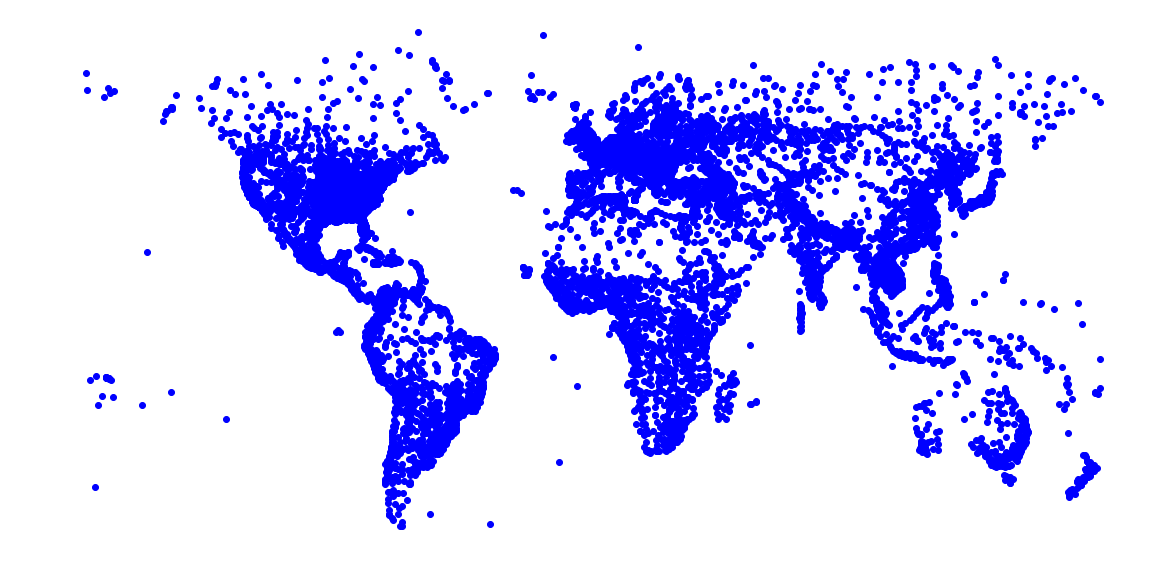

In [4]:
plt.figure(figsize = (20,10))
plt.scatter(X[:,0], X[:,1], c='b')
plt.axis('off')
plt.show()

# Kd tree

In [5]:
class KD_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.mins = mins
        self.maxs = maxs
        self.direction = None        
        self.pivot = None
        self.left = None
        self.right = None

In [6]:
def split(X, index, method):
    '''Split method (max spread or max variance)
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray
        Sample indices, within range(n_samples)
    method : str, 'maxspread' or 'maxvariance'
        Method 
        
    Returns
    -------
    k : int
        Direction, in range(n_features)
    i : int
        Pivot, in range(n_samples)
    '''
    if method == 'maxspread':
        # max spread
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        k = np.argmax(maxs - mins)
        middle = (maxs[k] + mins[k]) / 2
        i = index[np.argmin(np.abs(X[index,k] - middle))]
    else:
        # max variance
        k = np.argmax(np.std(X[index], axis = 0))
        i = index[np.argsort(X[index,k])[len(index) // 2]]
    return k, i

In [7]:
def build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread'):
    '''Build the kd-tree from data.
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray or None
        Sample indices, within range(n_samples)
    ancestor : KD_Tree or None
        Ancestor of the current node
    mins : np.ndarray or None
        Min values of the rectangle, shape (n_features,)
    maxs : np.ndarray
        Max values of the rectangle, shape (n_features,)
    leaf_size : int
        Leaf size of the kd-tree 
    method : str, 'maxspread' or 'maxvariance'
        Split method 
        
    Returns
    -------
    tree : KD_Tree
        kd-tree
    '''
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
    tree = KD_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_kd_tree(X, index_left, tree, mins, maxs_, leaf_size, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_kd_tree(X, index_right, tree, mins_, maxs, leaf_size, method)
    return tree

In [8]:
def search_leaf(x, X, tree):
    '''Search the leaf node of the kd-tree given some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    tree : KD_Tree
        Leaf node
    '''
    if tree.pivot is not None:
        k = tree.direction
        i = tree.pivot
        if x[k] <= X[i,k]:
            return search_leaf(x, X, tree.left)
        else:
            return search_leaf(x, X, tree.right)
    else:
        return tree

In [9]:
def nn_search_kd_tree(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

In [10]:
def knn_search_kd_tree(k, x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    knn = []
    if len(index):
        knn = index[np.argsort(np.linalg.norm(X[index] - x, axis=1))[:k]]
        dist = max(np.linalg.norm(X[knn] - x, axis=1))
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if knn is None or np.linalg.norm(X[node.pivot] - x) < dist:            
            index_and_pivot = np.concatenate((index, [node.pivot]))
            knn = index_and_pivot[np.argsort(np.linalg.norm(X[index_and_pivot] - x, axis = 1))[:k]]
            dist = max(np.linalg.norm(X[knn] - x, axis=1))
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                knn_ = knn_search_kd_tree(k, x, X, tree_)
                dist_ = min(np.linalg.norm(X[knn_] - x, axis=1))
                if dist_ < dist:
                    knn_and_knn_ = np.concatenate((knn, knn_))
                    knn = knn_and_knn_[np.argsort(np.linalg.norm(X[knn_and_knn_] - x, axis = 1))[:k]]
                    dist = max(np.linalg.norm(X[knn] - x, axis=1))
                tree_.ancestor = ancestor
    return knn

## Building the KD tree

In [11]:
cities_tree = build_kd_tree(X)

## Closest city from the [Null Island](https://fr.wikipedia.org/wiki/Null_Island)

In [12]:
closest_city = nn_search_kd_tree((0,0), X, cities_tree)
cities.iloc[closest_city].city

'Sekondi'

## Closest cities from Paris

In [13]:
cities[cities.city == 'Paris']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6735,Paris,Paris,48.8667,2.3333,France,FR,FRA,Île-de-France,primary,9904000.0,1250015082
9269,Paris,Paris,33.6689,-95.5462,United States,US,USA,Texas,NaN,25961.0,1840020594
9624,Paris,Paris,36.2934,-88.3065,United States,US,USA,Tennessee,NaN,10576.0,1840014438
11088,Paris,Paris,39.6148,-87.6904,United States,US,USA,Illinois,NaN,8431.0,1840009542
12816,Paris,Paris,38.2015,-84.2717,United States,US,USA,Kentucky,NaN,12662.0,1840014315


The "true" Paris index is 6735, with lat=48.8667 and lng=2.3333.

In [14]:
paris_pos = (cities.iloc[6735]['lng'], cities.iloc[6735]['lat'])
knn_cities = knn_search_kd_tree(10, paris_pos, X, cities_tree)
cities.iloc[knn_cities]

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6735,Paris,Paris,48.8667,2.3333,France,FR,FRA,Île-de-France,primary,9904000.0,1250015082
6768,Versailles,Versailles,48.8005,2.1333,France,FR,FRA,Île-de-France,minor,85416.0,1250143827
6769,Melun,Melun,48.5333,2.6666,France,FR,FRA,Île-de-France,minor,249432.0,1250913458
6746,Amiens,Amiens,49.9004,2.3000,France,FR,FRA,Hauts-de-France,minor,143086.0,1250794759
6734,Orléans,Orleans,47.9004,1.9000,France,FR,FRA,Centre-Val de Loire,admin,217301.0,1250441405
6745,Rouen,Rouen,49.4304,1.0800,France,FR,FRA,Normandie,admin,532559.0,1250372069
6762,Arras,Arras,50.2833,2.7833,France,FR,FRA,Hauts-de-France,minor,64165.0,1250447540
6765,Auxerre,Auxerre,47.8004,3.5666,France,FR,FRA,Bourgogne-Franche-Comté,minor,41516.0,1250482884
6755,Dieppe,Dieppe,49.9337,1.0833,France,FR,FRA,Normandie,NaN,42461.0,1250006284
6752,Reims,Reims,49.2504,4.0300,France,FR,FRA,Grand Est,NaN,196565.0,1250608730


## Depth in Tree according to leaf size

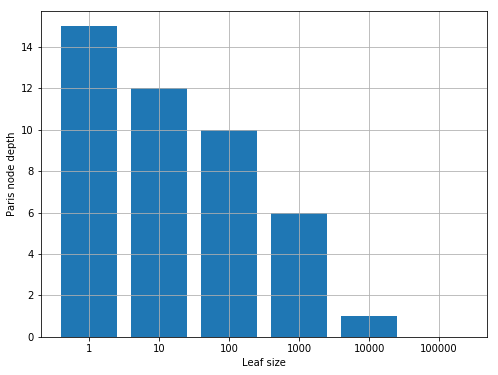

In [15]:
leaf_sizes = [1, 10, 100, 1000, 10000, 100000]
depths = []

for leaf_size in leaf_sizes:
    cities_tree = build_kd_tree(X, leaf_size=leaf_size)
    depth = 0
    paris_node = search_leaf(paris_pos, X, cities_tree)
    while paris_node.ancestor is not None:
        paris_node = paris_node.ancestor
        depth += 1
    depths.append(depth)

fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(range(len(leaf_sizes)), depths)
plt.xticks(range(len(leaf_sizes)), leaf_sizes)
plt.xlabel('Leaf size')
plt.ylabel('Paris node depth')
plt.show()

## 3-nearest neighbors Graph.

### Adjacency matrix

In [16]:
# First we build the adjacency matrix of 3 nearest neighbors
adjacency_matrix = np.zeros((len(X), len(X)))

for city_index in range(len(X)):
    knn = knn_search_kd_tree(4, X[city_index], X, cities_tree)
    adjacency_matrix[city_index, knn[1:]] = 1

### Graph

In [17]:
graph = csr_matrix(adjacency_matrix)

n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
labels = pd.DataFrame(labels, columns=['component_label'])

### Plotting 3 largest connected components in the graph

In [18]:
labels['component_label'].value_counts()[:3]

0    5333
9    4631
2    1068
Name: component_label, dtype: int64

In [19]:
first_comp_index = labels.component_label == 0
second_comp_index = labels.component_label == 9
third_comp_index = labels.component_label == 2

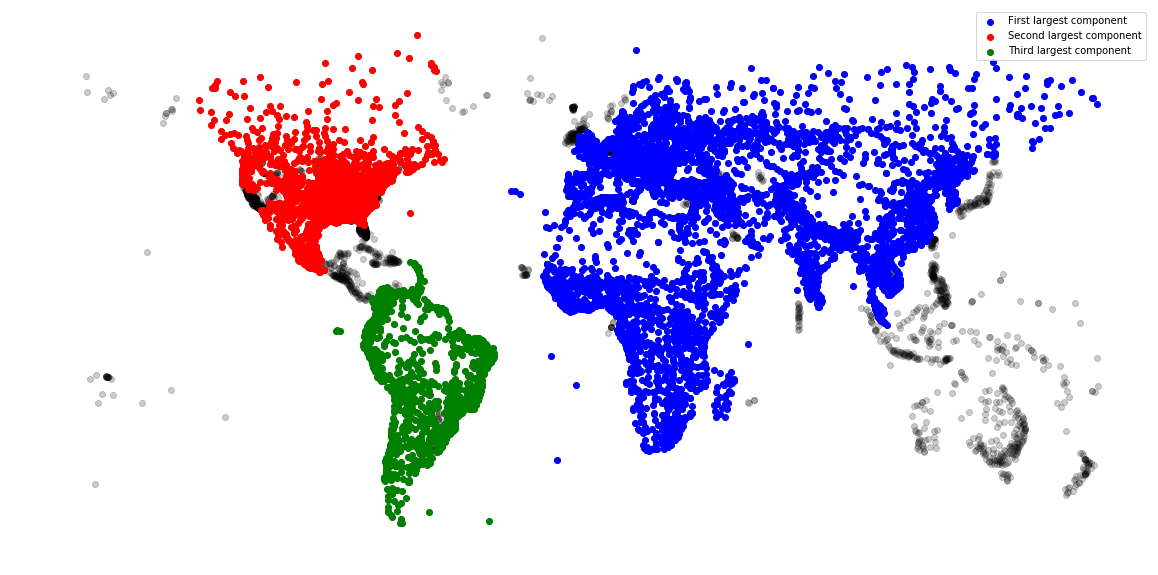

In [20]:
plt.figure(figsize = (20,10))
plt.scatter(X[:,0], X[:,1], c='k', alpha=0.2)
plt.scatter(X[first_comp_index,0], X[first_comp_index,1], c='b', label='First largest component')
plt.scatter(X[second_comp_index,0], X[second_comp_index,1], c='r', label='Second largest component')
plt.scatter(X[third_comp_index,0], X[third_comp_index,1], c='g', label='Third largest component')
plt.legend()
plt.axis('off')
plt.show()